<a href="https://colab.research.google.com/github/skyshine460/Datascience_notebook/blob/main/submit_moving29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [241]:
# 初期設定
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
from xgboost import XGBRegressor
# from catboost import CatBoostRegressor

from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

# データの読み込み

In [242]:
# 元データ
train = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/train.csv")
test = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/test.csv")
sample_submit = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/sample_submit.csv", header=None)

# EDA後のデータ

# Prophet予測後のデータ(testデータにはy=0が入っている)
train_merged_prophet = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/train_merged_prophet_21.csv")
test_merged_prophet = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/test_merged_prophet_21.csv")

In [243]:
train_merged_prophet.select_dtypes(include=['object']).columns.tolist()

['ds']

# データ変換

事前のEDAにより目的変数のBOXCOX変換を採用する

ProphetのトレンドをLightGBMに効果的に反映させるためには、次のような手法を検討できます：

トレンドの変換や強調：

Prophetのトレンドをそのまま使う代わりに、その1次差分や累積変化を計算し、特徴量として追加すると、トレンドの変化を捉えやすくなります。
例：trend_diff = trend.shift(1) - trend
トレンドに基づいた他の特徴量の生成：

Prophetで得られたトレンドを基に、他の変数との相互作用項を作ることで、トレンドの影響力を増加させることができます。
例：new_feature = trend * other_feature
トレンドを複数の時点で捉える：

過去のトレンドを遅れて反映させるラグ特徴量を生成する。
例：lagged_trend1 = trend.shift(1), lagged_trend2 = trend.shift(2)など。
LightGBMの正則化パラメータを調整：

LightGBMのmin_data_in_leafやfeature_fraction、num_leavesといったパラメータを調整し、トレンドがより強調されるような構造にする。
トレンドの重み付け：

トレンドが特に影響を与える時期や状況に基づいて、トレンドに対して重み付けを行い、重要性を高めることも有効です。

In [244]:
# datetime型へ変更
train_merged_prophet['ds'] = pd.to_datetime(train_merged_prophet['ds'])

In [245]:
# Box-Cox変換 λ = 1/2
train_merged_prophet["y_bc_1_2"] = (np.power(train_merged_prophet["y"], 1 / 2) - 1) / (1 / 2)
train_merged_prophet = train_merged_prophet.drop('y', axis=1)

In [246]:
# # Prophetのyhatの要素は用いない（モデルの酷似を避けるため）
# train_merged_prophet = train_merged_prophet.drop(['yhat', 'yhat_lower', 'yhat_upper'], axis=1)

# Box-Cox変換 λ = 1/2
train_merged_prophet["yhat_bc_1_2"] = (np.power(train_merged_prophet["yhat"], 1 / 2) - 1) / (1 / 2)
train_merged_prophet = train_merged_prophet.drop('yhat', axis=1)

In [247]:
def compare_columns(train, test):
  # train と test のカラム名をセットに変換
  train_columns = set(train.columns)
  test_columns = set(test.columns)

  # カラム名の差分を計算
  train_only = train_columns - test_columns
  test_only = test_columns - train_columns

  print("train only columns:", train_only)
  print("test only columns:", test_only)

In [248]:
# データ名変更
train_gbdt = train_merged_prophet.copy()

# '_upper' もしくは '_lower' を含むカラムを削除
columns_to_drop = [col for col in train_gbdt.columns if '_upper' in col or '_lower' in col]
train_gbdt = train_gbdt.drop(columns=columns_to_drop)

print(train_gbdt.columns.to_list())

['ds', 'client', 'price_am', 'price_pm', 'client_mean', 'price_am_mean', 'price_pm_mean', 'is_train', 'price_am_lag_1', 'price_pm_lag_1', 'price_am_lag_7', 'price_pm_lag_7', 'price_am_lag_30', 'price_pm_lag_30', 'price_am_lag_90', 'price_pm_lag_90', 'price_am_lag_365', 'price_pm_lag_365', 'price_am_moving_avg_7', 'price_am_moving_avg_30', 'price_am_moving_avg_90', 'price_pm_moving_avg_7', 'price_pm_moving_avg_30', 'price_pm_moving_avg_90', 'year', 'month', 'day', 'day_of_week', 'week_of_year', 'week_of_month', 'is_wknd', 'is_month_start', 'is_month_end', 'quarter', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end', 'is_holiday', 'season', 'rokuyo', 'golden_week', 'obon', 'new_year', 'JPNRGDPEXP', 'LRUN64TTJPM156S', 'JPNCPIALLMINMEI', 'QJPN628BIS', 'LCEAPR03JPM661S', 'JPNCPIHOUMINMEI', 'IRSTCB01JPM156N', 'trend', 'Autumnal Equinox', "Children's Day", 'Coming of Age Day', 'Constitution Day', 'Culture Day', "Emperor's Birthday", 'Foundation Day', 'Greenery Day', 'IRSTCB

In [249]:
# 指標データの特徴量を作成
economic_cols = ['JPNRGDPEXP', 'LRUN64TTJPM156S', 'JPNCPIALLMINMEI', 'QJPN628BIS', 'LCEAPR03JPM661S', 'JPNCPIHOUMINMEI', 'IRSTCB01JPM156N']

lags = [1, 7, 30, 90, 365]
for col in economic_cols:
    for lag in lags:
        # ラグ特徴量
        train_gbdt[f"{col}_lag_{lag}"] = train_gbdt[col].shift(lag)
        # 差分特徴量
        train_gbdt[f"{col}_diff_{lag}"] = train_gbdt[col].shift(lag) - train_gbdt[col]

train_gbdt = train_gbdt.fillna(0)

In [250]:
# Prophet予測データの特徴量を作成
forecast_cols = ['trend', 'holidays', 'monthly', 'multiplicative_terms', 'season_forecast', 'weekly', 'yearly', 'additive_terms']

lags = [1, 7, 30, 90, 365]
for col in forecast_cols:
    for lag in lags:
        # ラグ特徴量
        train_gbdt[f"{col}_lag_{lag}"] = train_gbdt[col].shift(lag)
        # 差分特徴量
        train_gbdt[f"{col}_diff_{lag}"] = train_gbdt[col].shift(lag) - train_gbdt[col]

train_gbdt = train_gbdt.fillna(0)

In [251]:
# testデータの変換

# datetime型へ変更
test_merged_prophet['ds'] = pd.to_datetime(test_merged_prophet['ds'])

# # Prophetのyhatの要素は用いない（モデルの酷似を避けるため）
# test_merged_prophet = test_merged_prophet.drop(['yhat', 'yhat_lower', 'yhat_upper'], axis=1)

# Box-Cox変換 λ = 1/2
test_merged_prophet["yhat_bc_1_2"] = (np.power(test_merged_prophet["yhat"], 1 / 2) - 1) / (1 / 2)
test_merged_prophet = test_merged_prophet.drop('yhat', axis=1)

# データ名変更
test_gbdt = test_merged_prophet.copy()

# '_upper' もしくは '_lower' を含むカラムを削除
columns_to_drop = [col for col in test_gbdt.columns if '_upper' in col or '_lower' in col]
test_gbdt = test_gbdt.drop(columns=columns_to_drop)

# 指標データの特徴量を作成
economic_cols = ['JPNRGDPEXP', 'LRUN64TTJPM156S', 'JPNCPIALLMINMEI', 'QJPN628BIS', 'LCEAPR03JPM661S', 'JPNCPIHOUMINMEI', 'IRSTCB01JPM156N']

lags = [1, 7, 30, 90, 365]
for col in economic_cols:
    for lag in lags:
        # ラグ特徴量
        test_gbdt[f"{col}_lag_{lag}"] = test_gbdt[col].shift(lag)
        # 差分特徴量
        test_gbdt[f"{col}_diff_{lag}"] = test_gbdt[col].shift(lag) - test_gbdt[col]

# Prophet予測データの特徴量を作成
forecast_cols = ['trend', 'holidays', 'monthly', 'multiplicative_terms', 'season_forecast', 'weekly', 'yearly', 'additive_terms']

lags = [1, 7, 30, 90, 365]
for col in forecast_cols:
    for lag in lags:
        # ラグ特徴量
        test_gbdt[f"{col}_lag_{lag}"] = test_gbdt[col].shift(lag)
        # 差分特徴量
        test_gbdt[f"{col}_diff_{lag}"] = test_gbdt[col].shift(lag) - test_gbdt[col]

test_gbdt = test_gbdt.fillna(0)

# カラムの比較
compare_columns(train_gbdt, test_gbdt)

train only columns: {'y_bc_1_2'}
test only columns: {'y'}


# 評価データでの検証

期間ごとに３つのfoldに変換する。


1.   tr:20110401-20130331, va:20130401-20140331
2.   tr:20120401-20140331, va:20140401-20150331
2.   tr:20130401-20150331, va:20150401-20160331

In [252]:
# 繁忙期を分ける（２月〜４月）
train_gbdt['busy'] = train_gbdt['month'].apply(lambda x: 1 if x in [3, 4] else 0)

train_busy = train_gbdt[train_gbdt['busy'] == 1].reset_index(drop=True)
train_nonbusy = train_gbdt[train_gbdt['busy'] == 0].reset_index(drop=True)

In [253]:
train_busy.head()

,ds,client,price_am,price_pm,client_mean,price_am_mean,price_pm_mean,is_train,price_am_lag_1,price_pm_lag_1,...,additive_terms_diff_1,additive_terms_lag_7,additive_terms_diff_7,additive_terms_lag_30,additive_terms_diff_30,additive_terms_lag_90,additive_terms_diff_90,additive_terms_lag_365,additive_terms_diff_365,busy
0,2011-03-01,0,1,1,40.748571,47.388646,51.140625,1,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2011-03-02,0,0,0,40.748571,34.931429,36.864745,1,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2011-03-03,0,0,0,40.748571,34.931429,36.864745,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2011-03-04,0,1,1,40.748571,47.388646,51.140625,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2011-03-05,0,2,1,40.748571,55.274510,51.140625,1,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [254]:
# 年度の初日をindex出力
dates = ["2011-04-01", "2012-04-01", "2013-04-01", "2014-04-01", "2015-04-01", "2016-03-31"]
index_busy = []
for date in dates:
    index_busy.append(train_busy[train_busy["ds"] == date].index)

index_busy_num = [idx[0] for idx in index_busy if len(idx) > 0]
index_busy = index_busy_num
print(index_busy)

[31, 92, 153, 214, 275, 335]


In [255]:
# 各期間の開始と終了のインデックス(busy)
tr_ranges_busy = [(index_busy[0], index_busy[2]), #20110401-20130331
                  (index_busy[1], index_busy[3]), #20120401-20140331
                  (index_busy[2], index_busy[4]) #20130401-20150331
                  ]
va_ranges_busy = [(index_busy[2], index_busy[3]), #20130401-20140331
                  (index_busy[3], index_busy[4]), #20140401-20150331
                  (index_busy[4], index_busy[5]) #20150401-20160331
                  ]

In [256]:
tr_ranges_busy

[(31, 153), (92, 214), (153, 275)]

In [257]:
# 年度の初日をindex出力
dates = ["2011-05-01", "2012-05-01","2013-05-01", "2014-05-01", "2015-05-01", "2016-01-31"]
index_nonbusy = []
for date in dates:
    index_nonbusy.append(train_nonbusy[train_nonbusy["ds"] == date].index)

index_nonbusy_num = [idx[0] for idx in index_nonbusy if len(idx) > 0]
index_nonbusy = index_nonbusy_num
print(index_nonbusy)

[59, 364, 668, 972, 1276, 1551]


In [258]:
# 各期間の開始と終了のインデックス(nonbusy)
tr_ranges_nonbusy = [(index_nonbusy[0], index_nonbusy[2]), #20110401-20130331
                  (index_nonbusy[1], index_nonbusy[3]), #20120401-20140331
                  (index_nonbusy[2], index_nonbusy[4]) #20130401-20150331
                  ]
va_ranges_nonbusy = [(index_nonbusy[2], index_nonbusy[3]), #20130401-20140331
                  (index_nonbusy[3], index_nonbusy[4]), #20140401-20150331
                  (index_nonbusy[4], index_nonbusy[5]) #20150401-20160331
                  ]

In [259]:
# datetime型をエポック秒（タイムスタンプ）に変換
train_busy['ds'] =train_busy['ds'].astype(int) / 1e9
train_nonbusy['ds'] =train_nonbusy['ds'].astype(int) / 1e9

In [260]:
# 各foldのトレーニングデータとバリデーションデータを作成
tr0_busy = train_busy[tr_ranges_busy[0][0]:tr_ranges_busy[0][1]]
va0_busy = train_busy[va_ranges_busy[0][0]:va_ranges_busy[0][1]]

tr1_busy = train_busy[tr_ranges_busy[1][0]:tr_ranges_busy[1][1]]
va1_busy = train_busy[va_ranges_busy[1][0]:va_ranges_busy[1][1]]

tr2_busy = train_busy[tr_ranges_busy[2][0]:tr_ranges_busy[2][1]]
va2_busy = train_busy[va_ranges_busy[2][0]:va_ranges_busy[2][1]]


# 特徴量と目的変数を分割
x_tr0_busy = tr0_busy.drop(['y_bc_1_2'], axis=1)
y_tr0_busy = tr0_busy['y_bc_1_2']
x_va0_busy = va0_busy.drop(['y_bc_1_2'], axis=1)
y_va0_busy = va0_busy['y_bc_1_2']

x_tr1_busy = tr1_busy.drop(['y_bc_1_2'], axis=1)
y_tr1_busy = tr1_busy['y_bc_1_2']
x_va1_busy = va1_busy.drop(['y_bc_1_2'], axis=1)
y_va1_busy = va1_busy['y_bc_1_2']

x_tr2_busy = tr2_busy.drop(['y_bc_1_2'], axis=1)
y_tr2_busy = tr2_busy['y_bc_1_2']
x_va2_busy = va2_busy.drop(['y_bc_1_2'], axis=1)
y_va2_busy = va2_busy['y_bc_1_2']

In [261]:
# 逆変換の関数
def inverse_transform_bc1_2(y_bc):
    return (y_bc * 0.5 + 1) ** 2

In [262]:
#  ハイパーパラメータの設定
params = {
    'boosting_type': 'gbdt',
    # 'objective': 'huber',
    'objective': 'regression',
    'alpha': 0.95,
    'metric': 'mae',
    'learning_rate': 0.05,
    'num_leaves': 32,
    'subsample': 0.7,
    'subsample_freq': 1,
    'feature_fraction': 0.8,
    'min_data_in_leaf': 5,
    'min_sum_hessian_in_leaf': 5,
    'n_estimators': 1000,
    "random_state": 123,
    "importance_type": "gain",
}

パラメータの説明

boosting_type: 'gbdt': 勾配ブースティング法GBDT（Gradient Boosting Decision Tree）を使用。基本的に変更なし。

objective: 'regression_l1': L1損失（MAE）を最小化する回帰モデル。

metric: 'mae': 評価指標としてMAEを使用。 rmseやhuberなども試す価値があり。

learning_rate: 0.05: 学習率。値は推奨範囲の中間値。値が小さいほど学習が遅くなり、過学習を防ぐが、学習に時間がかかる。

num_leaves: 32: 最大リーフ数。CVでの調整範囲: 20 ～ 150。

subsample: 0.7: 各イテレーションで使用するデータの割合。CVでの調整範囲: 0.5 ～ 1.0。小さくするとモデルのばらつきが増え、過学習を防ぐ。

subsample_freq: 1: subsampleを何イテレーションごとに実施するか。1は毎回サンプリングを行います。通常は1。

feature_fraction: 0.8: 各イテレーションで使用する特徴量の割合。CVでの調整範囲: 0.6 ～ 1.0。小さくするほどランダム性が増し、過学習が抑えられる傾向にあります。

min_data_in_leaf: 50: 各リーフにおけるデータの最小数。CVでの調整範囲: 10 ～ 100。モデルの複雑さが制御され、過学習が抑えらる。データ量が多いほど大きく、データが少ない場合は小さく設定するのが一般的。

min_sum_hessian_in_leaf: 50: リーフ内の勾配の最小値。CVでの調整範囲: 1 ～ 100。通常はデフォルト設定で十分だが、データが不均衡な場合に調整する。

n_estimators: 1000: ブースティングする決定木の数。CVでの調整範囲: 100 ～ 5000。learning_rateとバランスを取りつつ調整。通常はearly_stoppingを利用して調整。

random_state: 123: ランダムシード。

importance_type: 'gain': 特徴量の重要度の評価方法。gainはモデルが各特徴量によってどれだけの情報を得たかを示す。


In [263]:
def train_and_evaluate(x_tr, y_tr, x_va, y_va, model_name):
    # モデルの学習
    model = lgb.LGBMRegressor(**params)
    model.fit(x_tr,
              y_tr,
              eval_set=[(x_tr, y_tr), (x_va, y_va)],
              callbacks=[
                  lgb.early_stopping(stopping_rounds=50, verbose=False),
                  lgb.log_evaluation(0)
              ])

    import pickle

    # モデルの保存
    model_filename = f"{model_name}.h5"
    with open(model_filename, "wb") as f:
        pickle.dump(model, f, protocol=4)

    # 検証データでの予測
    y_va_pred_bc = model.predict(x_va)

    # 予測値を逆変換
    y_va_pred = inverse_transform_bc1_2(y_va_pred_bc)
    y_va_true = inverse_transform_bc1_2(y_va)

    # 元のスケールでMAEを計算
    mae_value = mean_absolute_error(y_va_true, y_va_pred)
    print(f"MAE: {mae_value}")

    # 特徴量の重要度を取得
    importance = pd.DataFrame({
        'feature': x_tr.columns,
        'importance': model.feature_importances_
    })
    # 重要度が大きい順に並べ替え
    importance = importance.sort_values(by='importance', ascending=False).reset_index(drop=True)
    display(importance.head(10))

    # # 特徴量の重要度をプロット
    # plt.figure(figsize=(10, 6))
    # plt.barh(importance['feature'], importance['importance'])
    # plt.title(f'Feature Importance')
    # plt.xlabel('Importance')
    # plt.ylabel('Features')
    # plt.tight_layout()
    # plt.show()

    # 評価データを可視化
    fig, ax = plt.subplots()

    y_va_true_trimmed = y_va_true
    y_va_true_trimmed.reset_index(drop=True, inplace=True)
    ax.plot(y_va_true, 'b-', label='Actual')
    ax.plot(y_va_pred, 'r-', label='Vaild')

    ax.set_xlabel('Datetime')
    ax.set_ylabel('y')

    return model


In [264]:
# 各foldごとにモデルを定義
model0_busy = "model_lgb_busy_fold0"
model1_busy = "model_lgb_busy_fold1"
model2_busy = "model_lgb_busy_fold2"

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead

,feature,importance
0,yhat_bc_1_2,3833.593428
1,multiplicative_terms,1064.107995
2,multiplicative_terms_lag_365,230.710410
3,LCEAPR03JPM661S_diff_30,141.196609
4,ds,132.950449
5,price_pm_moving_avg_90,96.978200
6,JPNCPIALLMINMEI_diff_1,83.079837
7,monthly_lag_1,80.525128
8,JPNCPIHOUMINMEI_forecast,74.107660
9,monthly_diff_1,72.302868


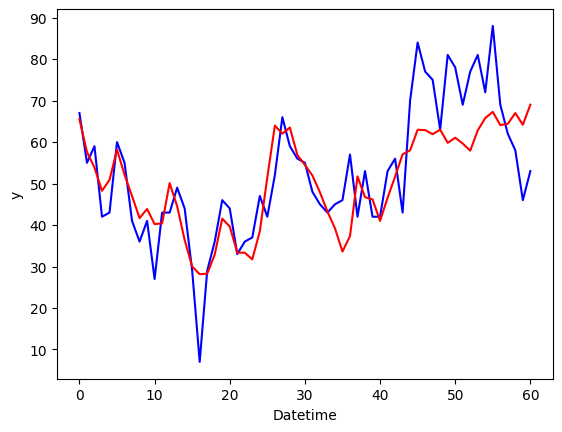

In [265]:
model0_busy_trained = train_and_evaluate(x_tr0_busy, y_tr0_busy, x_va0_busy, y_va0_busy, model0_busy)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead

,feature,importance
0,yhat_bc_1_2,2735.258499
1,multiplicative_terms_lag_365,979.611552
2,yearly_diff_30,234.012695
3,multiplicative_terms,184.980880
4,JPNCPIALLMINMEI_diff_7,121.753872
5,weekly,80.921769
6,multiplicative_terms_diff_30,78.464501
7,yearly_lag_365,77.097120
8,QJPN628BIS_lag_7,55.664899
9,weekly_diff_7,48.218654


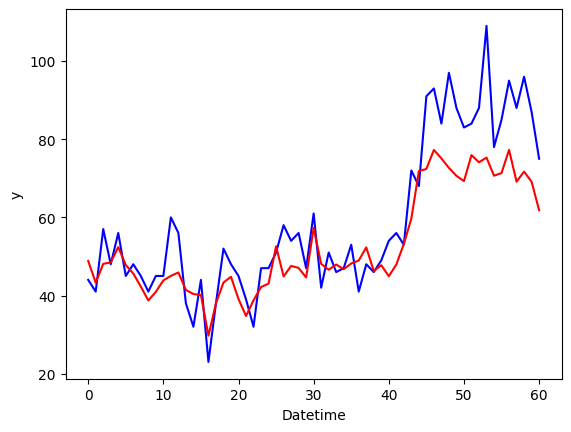

In [266]:
model1_busy_trained = train_and_evaluate(x_tr1_busy, y_tr1_busy, x_va1_busy, y_va1_busy, model1_busy)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_row_wise=true` to remove the overhead

,feature,importance
0,yhat_bc_1_2,1522.194159
1,multiplicative_terms_lag_365,1210.589375
2,yearly_diff_30,845.891042
3,multiplicative_terms,279.167449
4,yearly_lag_90,140.077883
5,multiplicative_terms_diff_30,132.865277
6,monthly_diff_7,109.020913
7,LRUN64TTJPM156S_diff_90,64.367810
8,weekly,58.036088
9,JPNCPIALLMINMEI_diff_7,54.205109


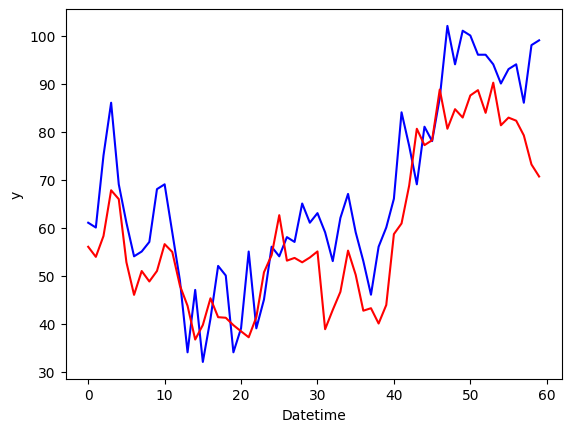

In [267]:
model2_busy_trained = train_and_evaluate(x_tr2_busy, y_tr2_busy, x_va2_busy, y_va2_busy, model2_busy)

In [268]:
# 各foldのトレーニングデータとバリデーションデータを作成
tr0_nonbusy = train_nonbusy[tr_ranges_nonbusy[0][0]:tr_ranges_nonbusy[0][1]]
va0_nonbusy = train_nonbusy[va_ranges_nonbusy[0][0]:va_ranges_nonbusy[0][1]]

tr1_nonbusy = train_nonbusy[tr_ranges_nonbusy[1][0]:tr_ranges_nonbusy[1][1]]
va1_nonbusy = train_nonbusy[va_ranges_nonbusy[1][0]:va_ranges_nonbusy[1][1]]

tr2_nonbusy = train_nonbusy[tr_ranges_nonbusy[2][0]:tr_ranges_nonbusy[2][1]]
va2_nonbusy = train_nonbusy[va_ranges_nonbusy[2][0]:va_ranges_nonbusy[2][1]]


# 特徴量と目的変数を分割
x_tr0_nonbusy = tr0_nonbusy.drop(['y_bc_1_2'], axis=1)
y_tr0_nonbusy = tr0_nonbusy['y_bc_1_2']
x_va0_nonbusy = va0_nonbusy.drop(['y_bc_1_2'], axis=1)
y_va0_nonbusy = va0_nonbusy['y_bc_1_2']

x_tr1_nonbusy = tr1_nonbusy.drop(['y_bc_1_2'], axis=1)
y_tr1_nonbusy = tr1_nonbusy['y_bc_1_2']
x_va1_nonbusy = va1_nonbusy.drop(['y_bc_1_2'], axis=1)
y_va1_nonbusy = va1_nonbusy['y_bc_1_2']

x_tr2_nonbusy = tr2_nonbusy.drop(['y_bc_1_2'], axis=1)
y_tr2_nonbusy = tr2_nonbusy['y_bc_1_2']
x_va2_nonbusy = va2_nonbusy.drop(['y_bc_1_2'], axis=1)
y_va2_nonbusy = va2_nonbusy['y_bc_1_2']

In [269]:
# 各foldごとにモデルを定義
model0_nonbusy = "model_lgb_nonbusy_fold0"
model1_nonbusy = "model_lgb_nonbusy_fold1"
model2_nonbusy = "model_lgb_nonbusy_fold2"

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_col_wise=true` to remove the overhead

,feature,importance
0,yhat_bc_1_2,19318.011629
1,price_am,1817.326076
2,multiplicative_terms,1688.583266
3,price_pm,1128.394095
4,multiplicative_terms_lag_1,663.530257
5,ds,406.848162
6,multiplicative_terms_diff_7,297.902474
7,monthly_diff_90,252.139254
8,multiplicative_terms_diff_1,237.398746
9,weekly_diff_7,224.972670


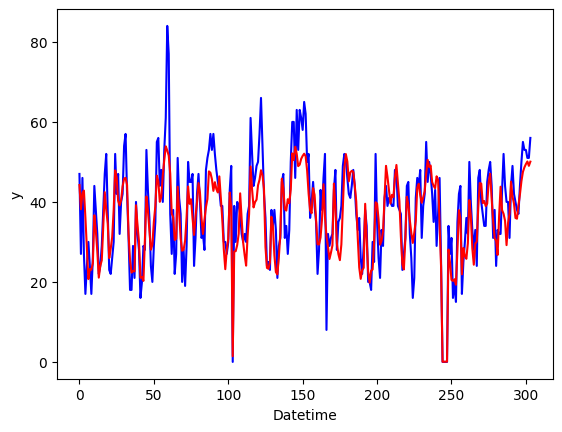

In [270]:
model0_nonbusy_trained = train_and_evaluate(x_tr0_nonbusy, y_tr0_nonbusy, x_va0_nonbusy, y_va0_nonbusy, model0_nonbusy)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002313 seconds.
You can set `force_col_wise=true` to remove the overhead

,feature,importance
0,yhat_bc_1_2,14954.730113
1,price_am,4691.083605
2,multiplicative_terms,2117.132821
3,price_pm,1302.765811
4,weekly,185.967987
5,multiplicative_terms_diff_1,176.407941
6,multiplicative_terms_lag_1,154.885881
7,multiplicative_terms_lag_7,143.341987
8,yearly_diff_1,139.454868
9,extra_regressors_multiplicative,123.827530


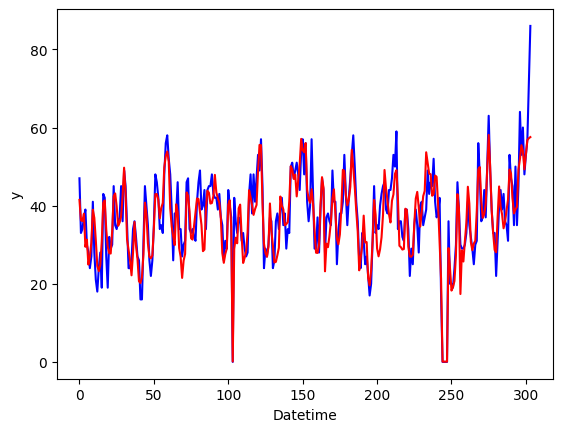

In [271]:
model1_nonbusy_trained = train_and_evaluate(x_tr1_nonbusy, y_tr1_nonbusy, x_va1_nonbusy, y_va1_nonbusy, model1_nonbusy)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003575 seconds.
You can set `force_col_wise=true` to remove the overhead

,feature,importance
0,price_am,7895.244686
1,yhat_bc_1_2,7046.010989
2,multiplicative_terms,3007.705532
3,price_pm,1658.194721
4,price_am_mean,931.027000
5,multiplicative_terms_lag_365,311.921053
6,multiplicative_terms_lag_7,193.691634
7,yearly,147.055700
8,multiplicative_terms_lag_1,133.977010
9,monthly_diff_30,110.711465


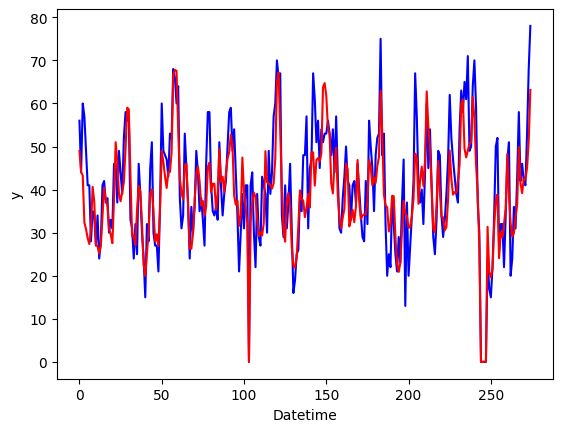

In [272]:
model2_nonbusy_trained = train_and_evaluate(x_tr2_nonbusy, y_tr2_nonbusy, x_va2_nonbusy, y_va2_nonbusy, model2_nonbusy)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_col_wise=true` to remove the overhead

,feature,importance
0,yhat_bc_1_2,8908.358138
1,multiplicative_terms_lag_365,1955.317367
2,multiplicative_terms,459.316237
3,JPNCPIALLMINMEI_diff_7,246.006980
4,ds,243.368450
5,JPNCPIHOUMINMEI,168.782171
6,monthly_diff_1,145.756978
7,JPNRGDPEXP,113.442425
8,monthly_diff_7,101.391393
9,LCEAPR03JPM661S_diff_30,94.038748


LGBMRegressor(alpha=0.95, feature_fraction=0.8, importance_type='gain',
              learning_rate=0.05, metric='mae', min_data_in_leaf=5,
              min_sum_hessian_in_leaf=5, n_estimators=1000, num_leaves=32,
              objective='regression', random_state=123, subsample=0.7,
              subsample_freq=1)

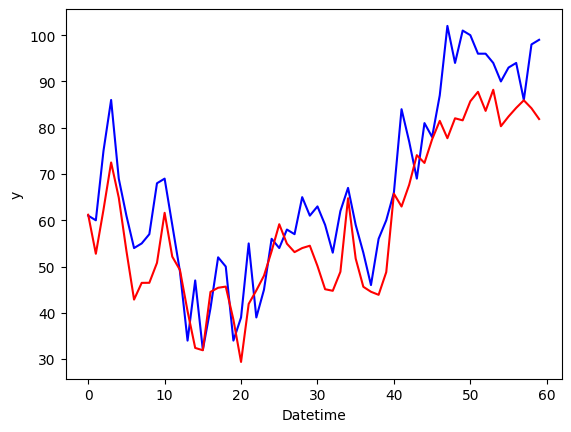

In [273]:
# データを最大限つかって評価
tr_ranges_busy = [index_busy[0], index_busy[4]] #20110401-20150331
va_ranges_busy = [index_busy[4], index_busy[5]] #20150401-20160331

tr3_busy = train_busy[tr_ranges_busy[0]: tr_ranges_busy[1]]
va3_busy = train_busy[va_ranges_busy[0]: va_ranges_busy[1]]

# 特徴量と目的変数を分割
x_tr3_busy = tr3_busy.drop(['y_bc_1_2'], axis=1)
y_tr3_busy = tr3_busy['y_bc_1_2']
x_va3_busy = va3_busy.drop(['y_bc_1_2'], axis=1)
y_va3_busy = va3_busy['y_bc_1_2']

model3_busy = "model_lgb_busy_fold3"
train_and_evaluate(x_tr3_busy, y_tr3_busy, x_va3_busy, y_va3_busy, model3_busy)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004522 seconds.
You can set `force_col_wise=true` to remove the overhead

,feature,importance
0,yhat_bc_1_2,31936.432934
1,multiplicative_terms,11329.982444
2,price_am,6895.753578
3,JPNCPIHOUMINMEI,2075.997257
4,multiplicative_terms_lag_1,1463.483509
5,ds,1329.141612
6,price_am_mean,673.446920
7,price_pm,584.524359
8,multiplicative_terms_diff_1,367.345685
9,multiplicative_terms_diff_7,313.295542


LGBMRegressor(alpha=0.95, feature_fraction=0.8, importance_type='gain',
              learning_rate=0.05, metric='mae', min_data_in_leaf=5,
              min_sum_hessian_in_leaf=5, n_estimators=1000, num_leaves=32,
              objective='regression', random_state=123, subsample=0.7,
              subsample_freq=1)

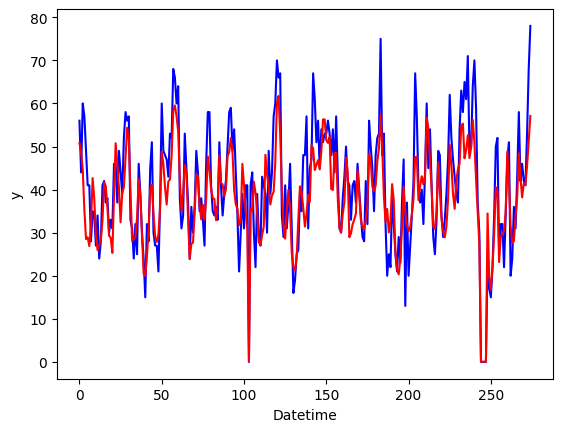

In [274]:
# データを最大限つかって評価
tr_ranges_nonbusy = [index_nonbusy[0], index_nonbusy[4]] #20110401-20150331
va_ranges_nonbusy = [index_nonbusy[4], index_nonbusy[5]] #20150401-20160331

tr3_nonbusy = train_nonbusy[tr_ranges_nonbusy[0]: tr_ranges_nonbusy[1]]
va3_nonbusy = train_nonbusy[va_ranges_nonbusy[0]: va_ranges_nonbusy[1]]

# 特徴量と目的変数を分割
x_tr3_nonbusy = tr3_nonbusy.drop(['y_bc_1_2'], axis=1)
y_tr3_nonbusy = tr3_nonbusy['y_bc_1_2']
x_va3_nonbusy = va3_nonbusy.drop(['y_bc_1_2'], axis=1)
y_va3_nonbusy = va3_nonbusy['y_bc_1_2']

model3_nonbusy = "model_lgb_nonbusy_fold3"
train_and_evaluate(x_tr3_nonbusy, y_tr3_nonbusy, x_va3_nonbusy, y_va3_nonbusy, model3_nonbusy)



*   凹凸の位置は概ねあっているので問題なし
*   繁忙期など上に凸のピークがフィットしていない。下に凸はかなりあっている
*   prophetのuppwerやlowerは信頼度範囲なので特徴量として影響が予測値より高いのはモデル性能を下げているように思える。




upper, lowerのデータの削除、評価指標としてHuber Lossを採用する

In [275]:
#  ハイパーパラメータの再設定
params = {
    'boosting_type': 'gbdt',
    # 'objective': 'huber',
    'objective': 'regression',
    'alpha': 0.95,
    'metric': 'mae',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'subsample': 0.7,
    'subsample_freq': 1,
    'feature_fraction': 0.8,
    'min_data_in_leaf': 10,
    'min_sum_hessian_in_leaf': 10,
    'n_estimators': 1000,
    "random_state": 123,
    "importance_type": "gain",
}

In [276]:
# trainに合わせた目的変数の作成
test_gbdt = test_gbdt.rename(columns={"y": 'y_bc_1_2'})

compare_columns(train_gbdt, test_gbdt)

train only columns: {'busy'}
test only columns: set()


In [277]:
# 繁忙期を分ける（２月〜４月）
test_gbdt['busy'] = test_gbdt['month'].apply(lambda x: 1 if x in [3, 4] else 0)

test_busy = test_gbdt[test_gbdt['busy'] == 1].reset_index(drop=True)
test_nonbusy = test_gbdt[test_gbdt['busy'] == 0].reset_index(drop=True)

In [278]:
# datetime型をエポック秒（タイムスタンプ）に変換
test_busy['ds'] =test_busy['ds'].astype(int) / 1e9
test_nonbusy['ds'] =test_nonbusy['ds'].astype(int) / 1e9

In [279]:
# 休業日の日付リストを定義
closed_day = {"2016-08-16", "2016-12-31", "2017-01-01", "2017-01-02", "2017-01-03"}
closed_index = {137, 274, 275, 276, 277}

# 任意に作成したfoldのアンサンブルモデル

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the 

,feature,importance
0,yhat_bc_1_2,8493.024861
1,multiplicative_terms_lag_365,1868.258651
2,multiplicative_terms,566.211909
3,LCEAPR03JPM661S_diff_30,222.789882
4,JPNCPIHOUMINMEI,217.862238
5,JPNCPIALLMINMEI_diff_7,182.275315
6,ds,174.687601
7,LRUN64TTJPM156S_lag_90,170.110238
8,yearly_diff_30,158.300600
9,JPNRGDPEXP,150.556044


LGBMRegressor(alpha=0.95, feature_fraction=0.8, importance_type='gain',
              learning_rate=0.05, metric='mae', min_data_in_leaf=10,
              min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=64,
              objective='regression', random_state=123, subsample=0.7,
              subsample_freq=1)

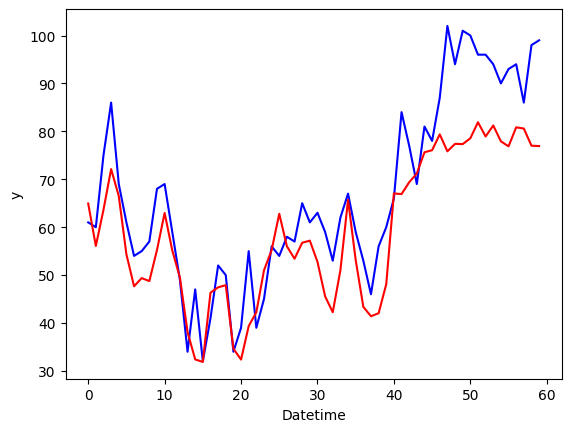

In [280]:
# データを最大限つかって評価
tr_ranges_busy = [index_busy[0], index_busy[4]] #20110401-20150331
va_ranges_busy = [index_busy[4], index_busy[5]] #20150401-20160331

tr3_busy = train_busy[tr_ranges_busy[0]: tr_ranges_busy[1]]
va3_busy = train_busy[va_ranges_busy[0]: va_ranges_busy[1]]

# 特徴量と目的変数を分割
x_tr3_busy = tr3_busy.drop(['y_bc_1_2'], axis=1)
y_tr3_busy = tr3_busy['y_bc_1_2']
x_va3_busy = va3_busy.drop(['y_bc_1_2'], axis=1)
y_va3_busy = va3_busy['y_bc_1_2']

model3_busy = "model_lgb_busy_fold3"
train_and_evaluate(x_tr3_busy, y_tr3_busy, x_va3_busy, y_va3_busy, model3_busy)

In [281]:
# テストデータの準備
x_test_busy = test_busy.drop(['y_bc_1_2'], axis=1)

# 事前に保存されたモデルを読み込む
import pickle
with open("model_lgb_busy_fold3.h5", "rb") as f:
    model3_busy = pickle.load(f)

# 検証データでの予測
y_test_busy_pred_bc = model3_busy.predict(x_test_busy)

# 予測値を逆変換
y_test_busy_pred = inverse_transform_bc1_2(y_test_busy_pred_bc)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


In [282]:
average_prediction_busy = y_test_busy_pred

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004352 seconds.
You can set `force_col_wise=true` to remove the 

,feature,importance
0,yhat_bc_1_2,37491.456061
1,multiplicative_terms,8488.154520
2,price_am,5661.710144
3,price_pm,1725.876510
4,JPNCPIHOUMINMEI,1139.130965
5,price_am_mean,520.580090
6,multiplicative_terms_lag_1,436.351609
7,trend_lag_365,431.123704
8,JPNRGDPEXP,416.691353
9,trend,329.734164


LGBMRegressor(alpha=0.95, feature_fraction=0.8, importance_type='gain',
              learning_rate=0.05, metric='mae', min_data_in_leaf=10,
              min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=64,
              objective='regression', random_state=123, subsample=0.7,
              subsample_freq=1)

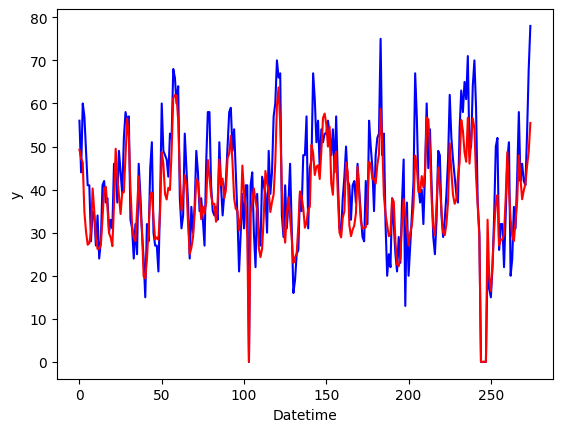

In [283]:
# データを最大限つかって評価
tr_ranges_nonbusy = [index_nonbusy[0], index_nonbusy[4]] #20110401-20150331
va_ranges_nonbusy = [index_nonbusy[4], index_nonbusy[5]] #20150401-20160331

tr3_nonbusy = train_nonbusy[tr_ranges_nonbusy[0]: tr_ranges_nonbusy[1]]
va3_nonbusy = train_nonbusy[va_ranges_nonbusy[0]: va_ranges_nonbusy[1]]

# 特徴量と目的変数を分割
x_tr3_nonbusy = tr3_nonbusy.drop(['y_bc_1_2'], axis=1)
y_tr3_nonbusy = tr3_nonbusy['y_bc_1_2']
x_va3_nonbusy = va3_nonbusy.drop(['y_bc_1_2'], axis=1)
y_va3_nonbusy = va3_nonbusy['y_bc_1_2']

model3_nonbusy = "model_lgb_nonbusy_fold3"
train_and_evaluate(x_tr3_nonbusy, y_tr3_nonbusy, x_va3_nonbusy, y_va3_nonbusy, model3_nonbusy)

In [284]:
# テストデータの準備
x_test_nonbusy = test_nonbusy.drop(['y_bc_1_2'], axis=1)

# 事前に保存されたモデルを読み込む
import pickle
with open("model_lgb_nonbusy_fold3.h5", "rb") as f:
    model3_nonbusy = pickle.load(f)

# 検証データでの予測
y_test_nonbusy_pred_bc = model3_nonbusy.predict(x_test_nonbusy)

# 予測値を逆変換
y_test_nonbusy_pred = inverse_transform_bc1_2(y_test_nonbusy_pred_bc)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


In [285]:
average_prediction_nonbusy = y_test_nonbusy_pred

# TimeSeriesSplitによるCV評価のモデル

In [286]:
# from sklearn.metrics import mean_absolute_error
# from sklearn.model_selection import TimeSeriesSplit
# import pickle

# def train_and_evaluate_cv(x, y, model_name, n_splits=5):
#     # TimeSeriesSplitを使用してクロスバリデーション
#     tscv = TimeSeriesSplit(n_splits=n_splits)
#     fold = 0
#     mae_scores = []

#     for train_index, val_index in tscv.split(x):
#         # 各foldごとにデータを分割
#         x_tr, x_va = x.iloc[train_index], x.iloc[val_index]
#         y_tr, y_va = y.iloc[train_index], y.iloc[val_index]

#         # モデルの学習
#         model = lgb.LGBMRegressor(**params)
#         model.fit(x_tr,
#                   y_tr,
#                   eval_set=[(x_tr, y_tr), (x_va, y_va)],
#                   callbacks=[
#                       lgb.early_stopping(stopping_rounds=50, verbose=False),
#                       lgb.log_evaluation(0)
#                   ])

#         # モデルの保存
#         model_filename = f"{model_name}_fold{fold}.h5"
#         with open(model_filename, "wb") as f:
#             pickle.dump(model, f, protocol=4)

#         # 検証データでの予測
#         y_va_pred_bc = model.predict(x_va)

#         # 予測値を逆変換
#         y_va_pred = inverse_transform_bc1_2(y_va_pred_bc)
#         y_va_true = inverse_transform_bc1_2(y_va)


#         # MAEを計算
#         mae_value = mean_absolute_error(y_va_true, y_va_pred)
#         mae_scores.append(mae_value)
#         print(f"Fold {fold} MAE: {mae_value}")

#         # 次のfoldへ
#         fold += 1

#     # 全foldの平均MAEを表示
#     avg_mae = sum(mae_scores) / len(mae_scores)
#     print(f"Average MAE: {avg_mae}")


In [287]:
# tr_busy = train_busy
# x_tr_busy = tr_busy.drop(['y_bc_1_2'], axis=1)
# y_tr_busy = tr_busy['y_bc_1_2']
# train_and_evaluate_cv(x_tr_busy, y_tr_busy, "model_lgb_busy_cv", n_splits=5)

In [288]:
# tr_nonbusy = train_nonbusy
# x_tr_nonbusy = tr_nonbusy.drop(['y_bc_1_2'], axis=1)
# y_tr_nonbusy = tr_nonbusy['y_bc_1_2']
# train_and_evaluate_cv(x_tr_nonbusy, y_tr_nonbusy, "model_lgb_nonbusy_cv", n_splits=5)

In [289]:
# def load_models_and_predict(model_name, n_splits, x_test):
#     predictions = []

#     for fold in range(n_splits):
#         model_filename = f"{model_name}_fold{fold}.h5"

#         # モデルの読み込み
#         with open(model_filename, "rb") as f:
#             model = pickle.load(f)

#         # テストデータでの予測
#         y_pred_bc = model.predict(x_test)

#         # 予測値を逆変換
#         y_pred = inverse_transform_bc1_2(y_pred_bc)
#         predictions.append(y_pred)


#     # 予測値の平均を計算
#     average_prediction = np.mean(predictions, axis=0)

#     return average_prediction


In [290]:
# x_test_busy = test_busy.drop(['y_bc_1_2'], axis=1)
# average_prediction_busy = load_models_and_predict("model_lgb_busy_cv", 5, x_test_busy)
# average_prediction_busy

In [291]:
# x_test_nonbusy = test_nonbusy.drop(['y_bc_1_2'], axis=1)
# average_prediction_nonbusy = load_models_and_predict("model_lgb_nonbusy_cv", 5, x_test_nonbusy)
# average_prediction_nonbusy

# グラフ描画

In [292]:
average_prediction = [0] * 365

# 繁忙期（busy）の部分を割り当て
average_prediction[31:] = average_prediction_busy[31:]
average_prediction[:-30] = average_prediction_busy[:-30]

# 繁忙期でない部分（nonbusy）の割り当て
average_prediction[31:-30] = average_prediction_nonbusy

# 休業日の実績を0とする
closed_day = {137, 274, 275, 276, 277}
for index in closed_day:
    if index < len(average_prediction):
        average_prediction[index] = 0

print(average_prediction)
print(len(average_prediction))

[63.477618582990786, 63.430288707883626, 63.05697878227234, 64.68467096147693, 50.83791771253264, 50.44405226705562, 49.8510763603289, 63.94097537676936, 64.32969173143091, 64.31194395524994, 49.895855452011475, 44.762349449804766, 41.98438606191986, 42.748853020823894, 43.07222443002725, 50.363295901511286, 48.57701775298056, 39.79417616376033, 30.806724995930928, 32.80807190241948, 39.78646080938558, 45.71176570450009, 58.11363437930386, 64.74551054672074, 51.77840550319192, 52.66204692016587, 60.123962740688434, 65.48082819632845, 65.2297101079954, 64.59253399259877, 62.74204256908157, 59.359923255824526, 41.3051626938766, 35.616291931981046, 30.672227832697608, 27.029475811054592, 26.995410316975047, 42.209818800643674, 37.53184276895268, 30.437787340670894, 23.94532949165512, 24.980158144243987, 26.739955470327065, 34.550939817608636, 45.538406447728555, 44.00672662995116, 32.691914169920764, 27.270782129417576, 27.313941554591114, 25.971377288595217, 34.78192269217666, 45.6956712

Text(0, 0.5, 'y')

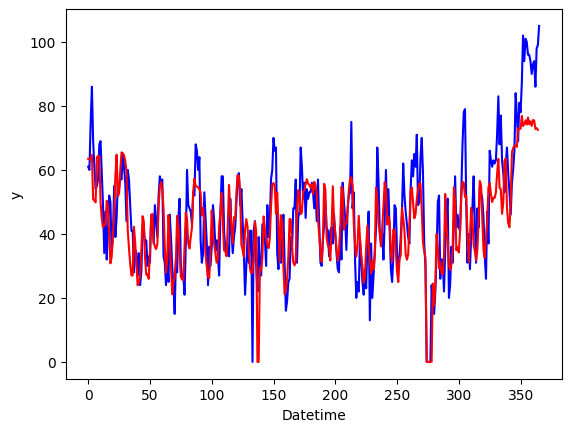

In [293]:
baseline = train_merged_prophet[1551: 1917].reset_index()
baseline['y'] = inverse_transform_bc1_2(baseline['y_bc_1_2'])



# testデータを可視化
fig, ax = plt.subplots()

ax.plot(baseline['y'], 'b-', label='baseline')
ax.plot(average_prediction, 'r-', label='test')

ax.set_xlabel('Datetime')
ax.set_ylabel('y')

In [294]:
df_submit = pd.DataFrame({
    'datetime': sample_submit[0],
    'y': average_prediction
})
pd.set_option('display.max_rows', None)
print(df_submit)

       datetime          y
0    2016-04-01  63.477619
1    2016-04-02  63.430289
2    2016-04-03  63.056979
3    2016-04-04  64.684671
4    2016-04-05  50.837918
5    2016-04-06  50.444052
6    2016-04-07  49.851076
7    2016-04-08  63.940975
8    2016-04-09  64.329692
9    2016-04-10  64.311944
10   2016-04-11  49.895855
11   2016-04-12  44.762349
12   2016-04-13  41.984386
13   2016-04-14  42.748853
14   2016-04-15  43.072224
15   2016-04-16  50.363296
16   2016-04-17  48.577018
17   2016-04-18  39.794176
18   2016-04-19  30.806725
19   2016-04-20  32.808072
20   2016-04-21  39.786461
21   2016-04-22  45.711766
22   2016-04-23  58.113634
23   2016-04-24  64.745511
24   2016-04-25  51.778406
25   2016-04-26  52.662047
26   2016-04-27  60.123963
27   2016-04-28  65.480828
28   2016-04-29  65.229710
29   2016-04-30  64.592534
30   2016-05-01  62.742043
31   2016-05-02  59.359923
32   2016-05-03  41.305163
33   2016-05-04  35.616292
34   2016-05-05  30.672228
35   2016-05-06  27.029476
3

In [295]:
df_submit.to_csv("submit_moving29.csv", index=False, header=False)